# Introduction

## Preface
My initial goal was to come up with some way to objectively measure defensive positioning, a defensive "score" if you will. Then, we can optimise this defensive score by reorganising a defence. If we achieve this, we would have a valuable tool where coaches can visualise trade-offs between risk and reward, such as when a full back presses tight instead of dropping off. We would also have the ability to suggest changes and how multiple players can move together to achieve an overall improvement in "defensive score" that the coach may not have considered. 

## What we will show

1. How to use an optimisation technique called Simulated Annealing to vibrate the defenders and move them around to find better positions.
2. How the new Annealer class can be used to optimise any arbitrary metric, such as Weighted Pitch Control and Pressure.
3. Future work that can be done based on this, as well as some immediate next steps.


## 1. What is Simulated Annealing?

There is a more detailed explanation [here](https://www.geeksforgeeks.org/artificial-intelligence/what-is-simulated-annealing). 

We follow through a straightforward loop outlined below to optimise any arbitrary objective:

1. Perturb the system by moving a randomly selected defensive player up to 0.2 yards in the x and y directions
2. Measure the objective of the perturbed solution (i.e. has the defensive score "improved" because of this player movement?)
3. If the score has improved, we should consider this perturbation to be positive, and keep it. Even if the score has gone down, we may want to keep the solution, as it will help if we get stuck inside a local maximum. The probability of keeping a bad score decreases as the system "cools"
4. Repeat

## 2. How to use the new Annealer class

### Data Setup

In [1]:
# !pip install -r requirements.txt

In [2]:
#imports
from src.simulated_annealing import generate_fig, run_annealer
from src.annealer import Annealer

from kloppy import skillcorner
from databallpy import get_game_from_kloppy
from databallpy.visualize import plot_soccer_pitch, plot_tracking_data
from databallpy.features.pitch_control import get_pitch_control_single_frame

import pandas as pd
import accessible_space
import pickle

import matplotlib.pyplot as plt

In [3]:
def plot_das_for_game(game_to_plot, input_fig = None, input_ax = None):
    df_long = game_to_plot.tracking_data[game_to_plot.tracking_data['frame']==selected_frame_idx].to_long_format()
    
    df_long["team"] = df_long["column_id"].str[:4]
    
    res = accessible_space.get_dangerous_accessible_space(
        df_long,
        frame_col="frame",
        period_col="period_id",
        player_col="column_id",
        team_col="team",
        x_col="x",
        y_col="y",
        vx_col="vx",
        vy_col="vy",
        team_in_possession_col="team_possession",
        player_in_possession_col="player_possession",
    )
    
    fig, ax = plot_soccer_pitch(pitch_color="white", fig = input_fig, ax = input_ax)
    fig, ax = plot_tracking_data(
        game_to_plot,
        game_to_plot.tracking_data[game_to_plot.tracking_data["frame"] == selected_frame_idx].index[0],
        fig=fig,
        ax=ax,
        title=f"Accessible space {res.acc_space.iloc[0]:.0f}m², DAS {res.das.iloc[0]:.2f}m²)",
        add_velocities=True,
    )

    #have to do this because plot_expected_completion_surface uses plt.gcf() instead of fig, ax interface 
    plt.figure(fig.number)   # make fig current
    plt.sca(ax)              # make ax current

    fig = accessible_space.plot_expected_completion_surface(
        res.dangerous_result,  # AS
        frame_index=0,
        color="blue",
    )
    return fig, ax

In [4]:
match_id = 1886347
tracking_data_github_url = f"https://media.githubusercontent.com/media/SkillCorner/opendata/master/data/matches/{match_id}/{match_id}_tracking_extrapolated.jsonl"
meta_data_github_url = f"https://raw.githubusercontent.com/SkillCorner/opendata/master/data/matches/{match_id}/{match_id}_match.json"

dataset = skillcorner.load(
    meta_data=meta_data_github_url,
    raw_data=tracking_data_github_url,
    # Optional Parameters
    coordinates="skillcorner",
    limit=500, 
)


#actual script
game = get_game_from_kloppy(dataset)
game.tracking_data.add_velocity(game.get_column_ids() + ["ball"], allow_overwrite=True)
game.tracking_data.add_individual_player_possession()
selected_frame_idx = 210 

/Users/amar/Documents/python_notebooks/dev_312/lib/python3.12/site-packages/databallpy/utils/get_game.py:865: UserWarning: All frames in 'tracking_dataset' are 'ALIVE', databallpy expects 'DEAD' frames as well (e.g. for more accurate event synchronization). Set `only_alive=False` in your kloppy `.load_tracking()` call to include 'DEAD' frames.
  warnings.warn(


### Situation to optimise
Here's the first situation we'll look at. In this case, we've visualised the pitch control of the teams using the standard pitch control model available in databallpy.

Here we see the Green team (Auckland FC) are about to make a pass from the LCB (#4), probably to #15 in the LB position.


(<Figure size 1200x800 with 1 Axes>, <Axes: >)

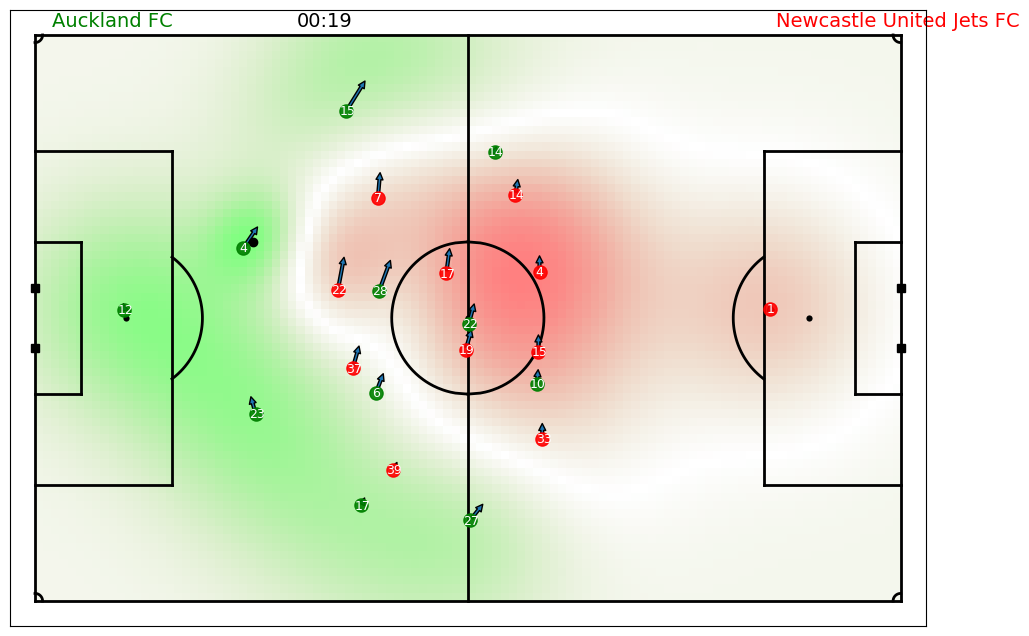

In [5]:
generate_fig(game, selected_frame_idx)

### Computing a Score for this situation

From this, we could compute various metrics about the red (defensive) team to quantify how good this position is. For example, we can compute the total pitch control of this position 

In [6]:
pc = get_pitch_control_single_frame(game.tracking_data[game.tracking_data['frame']==selected_frame_idx].iloc[0],
            game.pitch_dimensions,
            n_x_bins=106, n_y_bins=68,
        )
print(f"total pitch control: {sum(sum(pc))}")

total pitch control: 3690.9865385590947


### Maximising Weighted Pitch Control

* Now let's think about how we can improve this position. We could try to see how we can move the players to maximise pitch control.
* However, this would treat each square on the pitch as if it had the same value, so we'll use an xT weighted pitch control.
* In this case, our xT comes directly from a static model of Premier League xT from https://karun.in/blog/expected-threat.html , but we could, with more time, come up with something more complex that takes into account the specifics of this league

In [7]:
# Multiply each pitch control value by the associated threat in that position
with open("src/xTArray.pkl", "rb") as f:
    xt_array = pickle.load(f) #this assumes team is attacking from L to R, need to use np.fliplr if not
print(f"total weighted pitch control before optimisation: {sum(sum(xt_array*pc))}")

total weighted pitch control before optimisation: 127.52464911143325


In [13]:
# Now we need to optimise using our the Simulated Annealer
# NOTE: Simulated annealing is inherently random and therefore we may need to re-run this block multiple times until it finds a solution
annealer = Annealer(
            game, 
            selected_frame_idx, 
            distance_perturbation=0.2, # how many yards to randomly move the player on each iteration 
            max_distance_perturbation= 3, # the maximum distance we can move a player in any direction, x or y
            num_iterations=1000, # the number of perturbations to do
            weighted_pitch_control_parameter = 1 
        )
game_with_pitch_control, best_score = run_annealer(annealer, game)

running annealer
iteration 100 / 1000 best_score 193.9420766055302
iteration 200 / 1000 best_score 195.0125607114519
iteration 300 / 1000 best_score 196.37707941087677
iteration 400 / 1000 best_score 197.6361124318756
iteration 500 / 1000 best_score 198.6143019552357
iteration 600 / 1000 best_score 199.5041223100087
iteration 700 / 1000 best_score 199.85285837332947
iteration 800 / 1000 best_score 200.19510161956492
iteration 900 / 1000 best_score 200.42930982229922
best score 200.68955482645833


(<Figure size 1200x800 with 1 Axes>, <Axes: >)

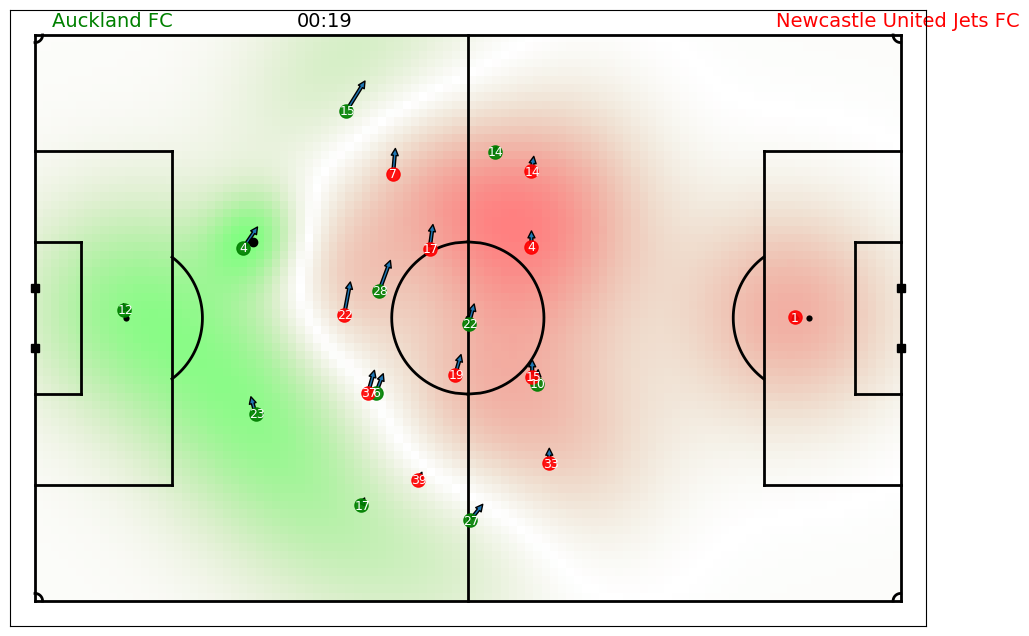

In [14]:
generate_fig(game_with_pitch_control, selected_frame_idx)

### Problem with Weighted Pitch Control

* Great, we've now moved the players and can clearly see that the optimiser was able to move the players to positions that maximise the objective function, in this case, xT Weighted Pitch Control.
* This has been achieved by spreading out the players more to cover the width, which was previously mainly occupied by the green team.
* The key problem here is that by only looking at Pitch Control, we've created a few holes in the defence, such as in the center circle around Green Player 22.
* We can visualise this by plotting the metric of Dangerous Accessible Space, or DAS, from the [accesible-space library](https://pypi.org/project/accessible-space/) / databallpy


Simulating passes: 100%|███████████████████████| 1/1 [00:00<00:00,  3.96chunk/s]


Text(0.5, 1.0, 'Weighted Pitch Control Optimized Accessible space 2841m², DAS 0.04m²)')

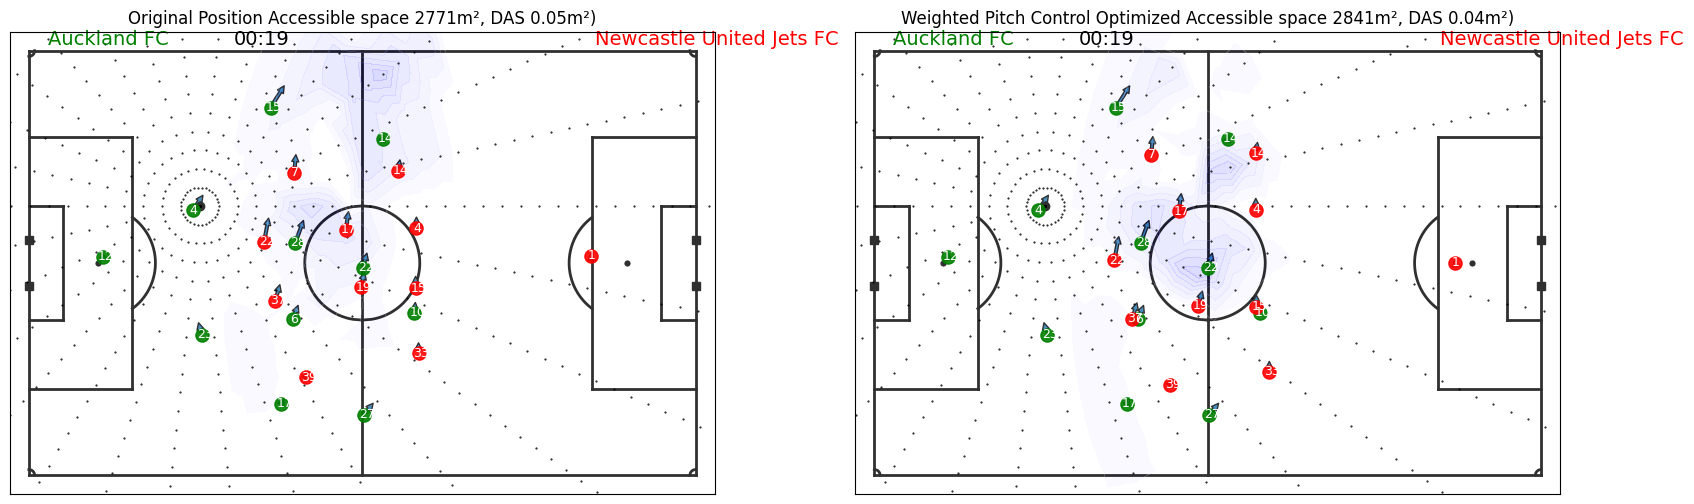

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

plot_das_for_game(game, input_fig=fig, input_ax=axs[0])
plot_das_for_game(game_with_pitch_control, input_fig=fig, input_ax=axs[1])

axs[0].set_title("Original Position " + axs[0].title._text)
axs[1].set_title("Weighted Pitch Control Optimized " + axs[1].title._text)

### Why we can't minimize AS/DAS

* Looking at Accessible Space (AS) before and after optimising for Weighted Pitch Control clearly shows that by optimising for this metric alone, we have created defensive leaks in the middle whilst plugging those out wide. This makes sense as even weighted pitch control can be maximised by the compact red defense becoming slightly wider.
  
* In an ideal world, we would try to minimize DAS/AS, however since this is simulation based, it takes too long to recalculate after every perturbation. Additionally, we can see that DAS is already just 0.05m², so this is quite a harsh metric to optimise.
    * I did get DAS working in the optimiser, and in future would like to explore if there is a faster way to re-compute DAS for just a small change in the input data (perturbation).

### Maximizing Pressure (and Weighted Pitch Control)


* As a proxy, I have simply added an objective term to optimise for pressing tight to certain players, using the mean value of databallpy's pressure metric for all players being pressed.
* This pressure value is between 0 and 100 per player, so I have added a weighting (pressing_parameter) and tried to maximise the mean pressure on Green players 22, 15, 28 and 14.

In [26]:
annealer = Annealer(
            game, 
            selected_frame_idx, 
            distance_perturbation=0.2, # how many yards to randomly move the player on each iteration 
            max_distance_perturbation= 3, # the maximum distance we can move a player in any direction, x or y
            num_iterations=1000, # the number of perturbations to do
            weighted_pitch_control_parameter = 1,
            pressing_parameter = 0.05, #multiplies how much the pressure objective is worth (it's a percentage so goes up to 100 per player)
            players_to_press = ['home_22', 'home_15', 'home_28', 'home_14']
        )
game_with_pitch_control_and_pressing, best_score = run_annealer(annealer, game)

running annealer
iteration 100 / 1000 best_score 194.1867403456864
iteration 200 / 1000 best_score 195.22802466486104
iteration 300 / 1000 best_score 196.45086392550536
iteration 400 / 1000 best_score 197.39758404723025
iteration 500 / 1000 best_score 198.6755670101334
iteration 600 / 1000 best_score 199.5348088609422
iteration 700 / 1000 best_score 200.54044851263615
iteration 800 / 1000 best_score 201.42470544555346
iteration 900 / 1000 best_score 201.63131804193318
best score 201.79141555479148


Simulating passes: 100%|███████████████████████| 1/1 [00:00<00:00,  3.18chunk/s]


Text(0.5, 1.0, 'Weighted Pitch Control + Pressure Optimized, Accessible space 2837m², DAS 0.04m²)')

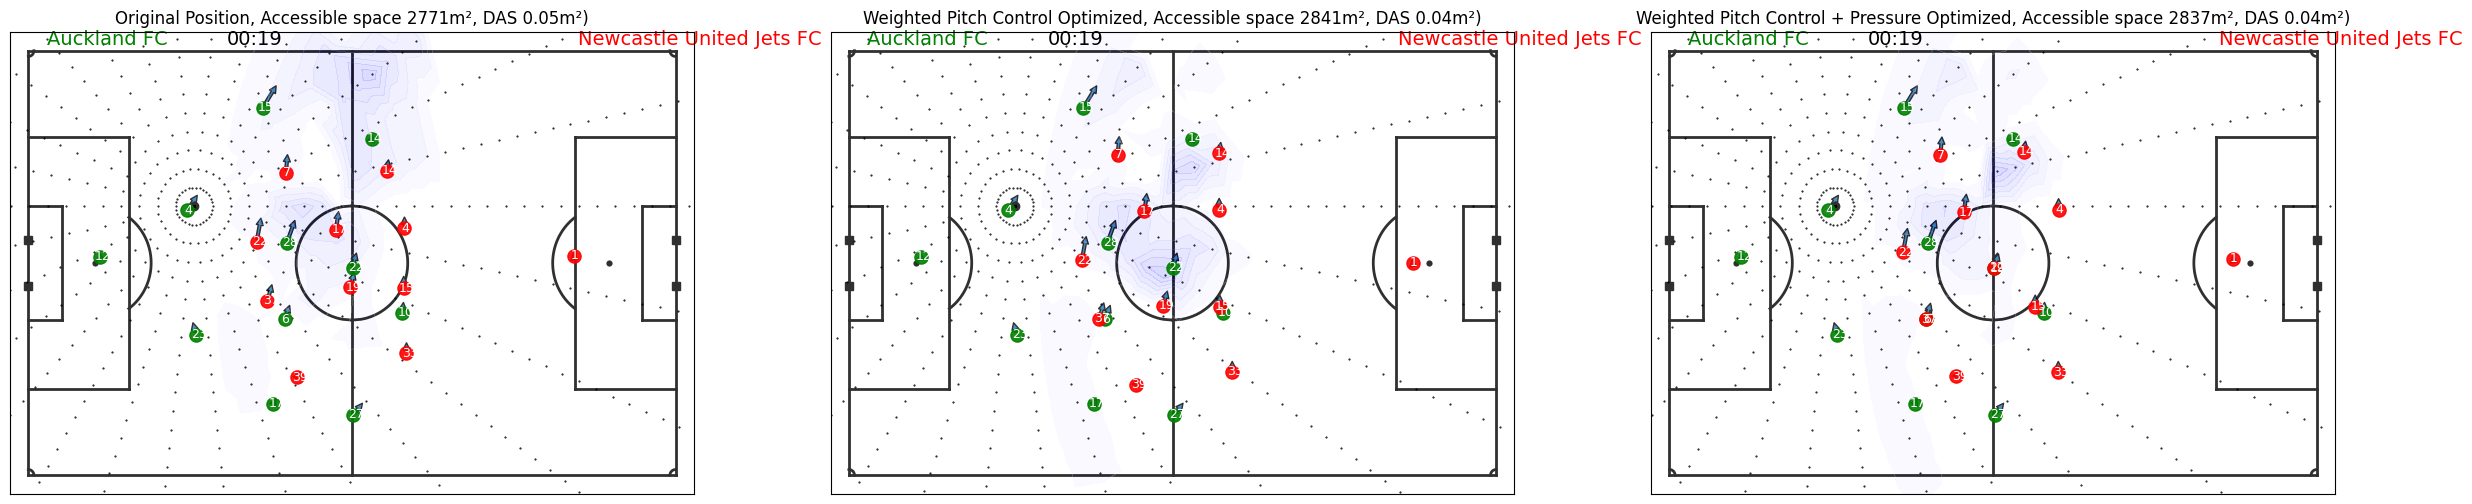

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(30, 6))

plot_das_for_game(game, input_fig=fig, input_ax=axs[0])
plot_das_for_game(game_with_pitch_control, input_fig=fig, input_ax=axs[1])
plot_das_for_game(game_with_pitch_control_and_pressing, input_fig=fig, input_ax=axs[2])

axs[0].set_title("Original Position, " + axs[0].title._text)
axs[1].set_title("Weighted Pitch Control Optimized, " + axs[1].title._text)
axs[2].set_title("Weighted Pitch Control + Pressure Optimized, " + axs[2].title._text)

Here are all 3 scenarios next to each other, from left to right: The original, the xT weighted Pitch Control, and the combination of xT weighted Pitch Control and Pressure.

Our optimiser has clearly increased pressure on those players whilst also increasing control of the pitch by making the Red defenders more spread out. If a team was using this, they might consider that in this situation there is too much space on the right hand side, and if they want to move their right players wider, they can make movements in the midfield to cover defensive gaps created by this increased width.

The metric could probably use some tweaking as we have still left a lot of space around player 22, and we may want to investigate a "per player" pressing_parameter.

## 3. Conclusions and Next Steps

In conclusion, we have achieved our two stated goals of 1. Coming up with an objective measure of defense for a specific situation, and 2. creating an optimisation algorithm that can improve that score. However, there is one major limitation and opportunity: the choice of metric. In this case, I have not chosen a particularly complex combination of metrics to optimise, and there are probably better ones to include as part of this optimisation.

Next steps with this project:

* Clean up the code and make the interface more accessible so that custom metrics can be added easily.
* See if we can add more pre-built objectives such as per player pressure, compactness, passing lane blockage etc.
* Improve on the MVP Streamlit app to create a tool that allows coaches to easily choose a tradeoff and optimise for that

Future work:

* See if this could be used for Attacking situations as well as Defensive ones
* Work with coaches to create a framework whereby coaches choose a tradeoff (e.g. we are 0-0 so I want to be 60% attacking and 40% defensive off the ball, or we are losing 1-0 so I want to now be 80% attacking and 20% defensive) and then visualise how they can reorganise players to objectively achieve certain tactics.
* Try to figure out a way to quickly compute DAS for a small perturbation without rerunning the simulations again.
* See if there is an approach to use Machine Learning or other automation that can translate tactics directly into Weights for the Annealer to use.